In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Model for RAVDESS dataset using 1d Convolutions

In [ ]:
import librosa
def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data

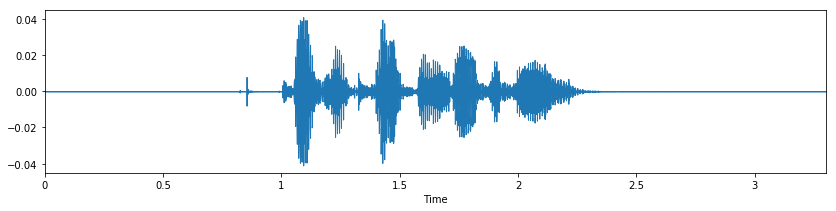

In [ ]:
from IPython.display import Audio
X, sample_rate = librosa.load('ravdess_data/Actor_01/03-01-01-01-01-01-01.wav', res_type='kaiser_fast')
X1 = noise(X)
plt.figure(figsize=(14, 3))
librosa.display.waveplot(X, sr=sample_rate)

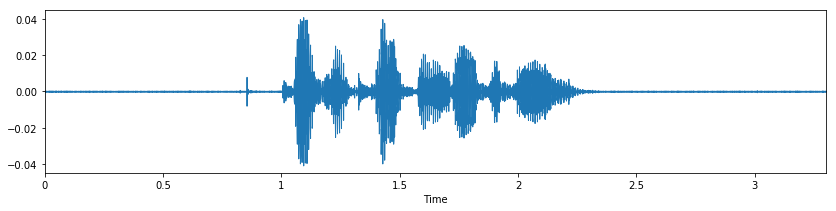

In [ ]:
import librosa.display
plt.figure(figsize=(14, 3))
librosa.display.waveplot(X1, sr=sample_rate)


Loading the RAVDESS speech actors data

In [ ]:
import os
import time
import librosa

lst_saral = []
lst_transpose = []
clear_lst = []
start_time = time.time()
for folder in os.listdir('ravdess_data/'):
  for file in os.listdir(f'{"ravdess_data/"}{folder}'):
      try:
        X, sample_rate = librosa.load(f'{"ravdess_data/"}{folder}{"/"}{file}', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
        mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=20)
        
        #Excluding the Calm Data
        file = int(file[7:8])-1
        if file>0:
          file-=1
        arr = mfccs, file
        lst.append(arr)
                
      except ValueError:
        continue

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

In [ ]:
ravdess_X, ravdess_y = zip(*lst_transpose) 

In [ ]:
# import pandas as pd
# lst = []
# df = pd.DataFrame(columns=['feature'])
# labels = []
# bookmark=0
# for folder in os.listdir('ravdess_data/'):
#   for file in os.listdir(f'{"ravdess_data/"}{folder}'):
#         X, sample_rate = librosa.load(f'{"ravdess_data/"}{folder}{"/"}{file}', res_type='kaiser_fast',)
#         sample_rate = np.array(sample_rate)
#         mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
#         feature = mfccs
#         file = int(file[7:8])-1
#         if file>0:
#           file-=1
#         #[float(i) for i in feature]
#         #feature1=feature[:135]
#         labels.append(file)
#         df.loc[bookmark] = [feature]
#         bookmark=bookmark+1


In [ ]:
df3 = pd.DataFrame(df['feature'].values.tolist())
df3 = df3.fillna(0)
features = df3.iloc[:, :-1]

In [ ]:
# ravdess_X, ravdess_y = drop_calm(ravdess_X, ravdess_y)
ravdess_X = np.asarray(features)
ravdess_y = np.asarray(labels)

In [ ]:
ravdess_X = np.expand_dims(ravdess_X, axis=2)
ravdess_train_X, ravdess_valid_X, ravdess_train_y, ravdess_valid_y  = train_test_split(ravdess_X,ravdess_y,test_size=0.2,random_state=42)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense
import numpy as np

# Expected input batch shape: (batch_size, timesteps, data_dim)
# Note that we have to provide the full batch_input_shape since the network is stateful.
# the sample of index i in batch k is the follow-up for the sample i in batch k-1.
model_ravdess = Sequential()
model_ravdess.add(LSTM(32))
model_ravdess.add(BatchNormalization())
model_ravdess.add(Dense(16, activation='softmax'))
model_ravdess.add(Dense(7, activation='softmax'))

opt = keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import train_test_split


model_ravdess = Sequential()

model_ravdess.add(Conv1D(32, 5,strides=2,padding='same',
                 input_shape=(215,1)))
model_ravdess.add(Activation('relu'))
model_ravdess.add(BatchNormalization())
# model_ravdess.add(MaxPooling1D(pool_size=(8)))
model_ravdess.add(Conv1D(64, 5,strides=2,padding='same',))
model_ravdess.add(Activation('relu'))
model_ravdess.add(BatchNormalization())
model_ravdess.add(Flatten())
model_ravdess.add(Dense(7))
model_ravdess.add(Activation('softmax'))
# opt = keras.optimizers.rmsprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0)


opt = keras.optimizers.Adam(lr=0.00005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
model_ravdess.summary()

ValueError: ignored

In [ ]:
np.any(np.isnan(ravdess_X))

False

In [ ]:
model_ravdess.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

In [ ]:
cnnhistory_ravdess=model_ravdess.fit(ravdess_train_X, ravdess_train_y, batch_size=16, epochs=10, validation_data=(ravdess_valid_X, ravdess_valid_y))

In [ ]:
model_ravdess.save('ravdess_clean_model.h5')

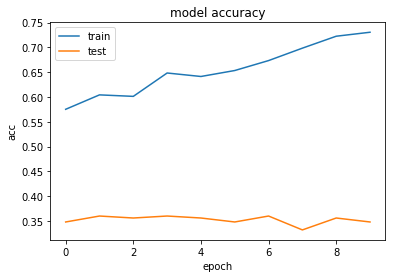

In [ ]:
plt.plot(cnnhistory_ravdess.history['acc'])
plt.plot(cnnhistory_ravdess.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('acc')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
import pandas as pd
test = []
bookmark=0
for file in os.listdir(f'{"test_data/"}'):
      X, sample_rate = librosa.load(f'{"test_data/"}{file}', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
      sample_rate = np.array(sample_rate)
      mfccs = librosa.feature.mfcc(y=X, 
                                          sr=sample_rate, 
                                          n_mfcc=13)
      feature = mfccs
#       file = int(file[7:8])-1
#       if file>0:
#         file-=1
      #[float(i) for i in feature]
      #feature1=feature[:135]
      file = 0
      test.append((feature,file))
      
test_X, test_y = zip(*test)

In [ ]:
test_X = np.asarray(test_X)
test_X.shape
test_X = test_X[:,:215]
test_X.shape

(2, 13, 216)

In [ ]:
test_X = np.expand_dims(test_X,axis=2)

In [ ]:
pred1=model_ravdess.predict_classes(test_X)
pred1
# Emotion (0 = Neutral, 1 = happy, 2 = sad, 3 = angry, 4 = fearful, 5 = disgust, 6 = surprised).


array([5, 4])

Model for TESS dataset using 1d Convolutions

Ensemble Learning on RAVDESS model and TESS model (Conv1d)

In [ ]:
!cp 'gdrive/My Drive/Filtered Data/41.wav' test_data

In [ ]:
test = np.array([])
labels = []
i =0

t = pd.DataFrame()

for file in os.listdir('test_data'):
  X, sample_rate = librosa.load(f'{"test_data/"}{file}', res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
  
  mfccs = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
  result = np.zeros((13,216))
  
  result[:mfccs.shape[0],:mfccs.shape[1]] = mfccs


In [ ]:
result.shape

(13, 216)

In [ ]:
arr = mfccs.reshape((2,13,216))

In [ ]:
arr.shape

(2, 13, 216)

In [ ]:
test_X, test_y = zip(*test)
test_X = np.asarray(test_X)

In [ ]:
test_X = np.expand_dims(test_X,axis=2)

In [ ]:
pred1=model_ravdess.predict_proba(test_X)
pred2=model_tess.predict_proba(test_X)
finalpred=(pred1*0.1+pred2*0.9)

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.utils import to_categorical
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split


model_tess = Sequential()

model_tess.add(Conv2D(32, 5,strides=2,padding='same',
                 input_shape=(13,216,1)))
model_tess.add(Activation('relu'))
model_tess.add(BatchNormalization())

# model_tess.add(MaxPooling1D(pool_size=(8)))
model_tess.add(Conv2D(64, 5,strides=2,padding='same',))
model_tess.add(Activation('relu'))
model_tess.add(BatchNormalization())

model_tess.add(Conv2D(64, 5,strides=2,padding='same',))
model_tess.add(Activation('relu'))
model_tess.add(BatchNormalization())

model_tess.add(Flatten())
model_tess.add(Dense(7))
model_tess.add(Activation('softmax'))
# opt = keras.optimizers.rmsprop(lr=0.00005, rho=0.9, epsilon=None, decay=0.0)


opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

In [ ]:
model_tess.summary()

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 7, 108, 32)        832       
_________________________________________________________________
activation_117 (Activation)  (None, 7, 108, 32)        0         
_________________________________________________________________
batch_normalization_64 (Batc (None, 7, 108, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 54, 64)         51264     
_________________________________________________________________
activation_118 (Activation)  (None, 4, 54, 64)         0         
_________________________________________________________________
batch_normalization_65 (Batc (None, 4, 54, 64)         256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 2, 27, 64)       